In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import itertools
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    """
    Recolour greyscale image `before` to new colour `bgr`
    in blue-green-red format
    
    Adapted from: https://stackoverflow.com/a/58142700
    """
    
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after


def overlay_images(img1, img2, h_shift, v_shift):
    """
    Recolour two greyscale images to red and green,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, h_shift],
        [0, 1, v_shift]
    ])
    
    img_1 = recolour_image(img1, bgr=[0, 0, 255])
    img_2 = recolour_image(img2, bgr=[0, 255, 0])
    img_2_shift = cv2.warpAffine(img_2, M, (img_2.shape[1], img_2.shape[0]))
    blended = cv2.addWeighted(img_1, 0.5, img_2_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def subtract_images(img1, img2, h_shift, v_shift):
    """
    Translate second image relative to first, and subtract
    """
    
    M = np.float32([
        [1, 0, h_shift],
        [0, 1, v_shift]
    ])
    
    img_2_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_2_shift)
    
    return subtracted


def misalignment(img1, img2, h_shift, v_shift):
    """
    Return sum of intensity in central half of difference 
    between two images, as measure of misalignment
    """
    
    x = subtract_images(img1, img2, h_shift, v_shift)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    
    return intensity


def align_images(img1, img2, frac):
    """
    Slide two images past each other and find offset which minimises misalignment
    """

    width = img1.shape[1]
    height = img1.shape[0]
    frac = frac  # decreasing factor tries larger range of offsets
    h_offsets = np.arange(-width // frac, width // frac)
    v_offsets = np.arange(-height // frac, height // frac)
    coords = list(itertools.product(h_offsets, v_offsets))
    misalignments = [misalignment(img1, img2, h_shift, v_shift) for h_shift, v_shift in tqdm(coords, desc='Trying possible offsets: ')]
    optimal_idx = np.argmin(misalignments)
    optimal = coords[optimal_idx]

    return optimal, coords, misalignments


def plot_alignment(img1, img2, frac=75):
    """
    Split image, align front and back projections, and plot
    """

    optimal, coords, misalignments = align_images(img1, img2, frac)
    (h_shift, v_shift) = optimal
    xs = [coord[0] for coord in coords]
    ys = [coord[1] for coord in coords]
    f, axes = plt.subplots(1, 3, figsize=(14, 5))
    axes[0].imshow(overlay_images(img1, img2, 0, 0).astype(np.uint8))
    axes[0].set_title("Original")
    axes[1].imshow(overlay_images(img1, img2, h_shift, v_shift).astype(np.uint8))
    axes[1].set_title(f"Aligned ({h_shift} px hor, {v_shift} px ver)")
    df = pd.DataFrame({"X": xs, "Y": ys, "Value": misalignments})
    table = df.pivot('Y', 'X', 'Value')
    sns.heatmap(table, ax=axes[2])
    axes[2].invert_yaxis()
    axes[2].set_title('Minimisation map')
    plt.tight_layout()
    plt.show()

    return coords, misalignments


def align_stack(filename):
    im = io.imread(filename)
    imgs = list(np.arange(0, im.shape[2]))
    for a, b in zip(imgs, imgs[1:]):
        print(f'Aligning image {a} vs {b}')
        img1 = im[:, :, a]
        img2 = im[:, :, b]
        coords, misalignments = plot_alignment(img1, img2)

Aligning image 0 vs 1


Trying possible offsets: 100%|██████████| 999/999 [00:12<00:00, 80.64it/s]


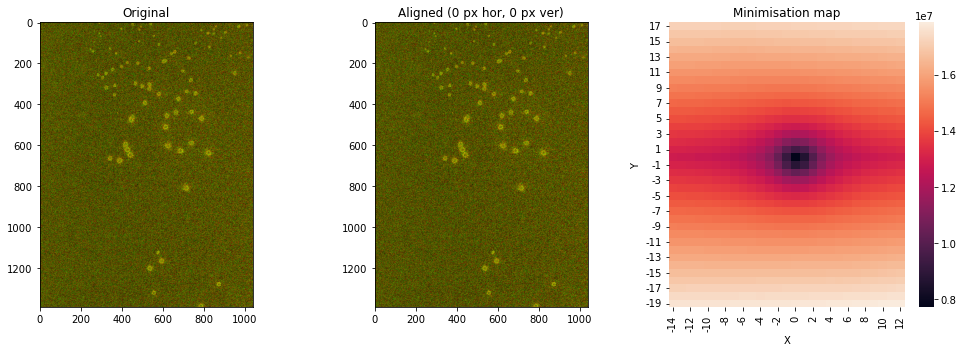

Aligning image 1 vs 2


Trying possible offsets: 100%|██████████| 999/999 [00:09<00:00, 105.79it/s]


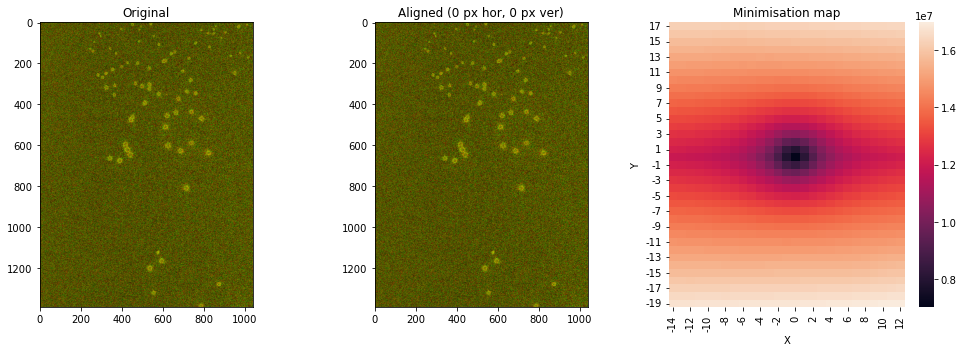

Aligning image 2 vs 3


Trying possible offsets: 100%|██████████| 999/999 [00:09<00:00, 100.87it/s]


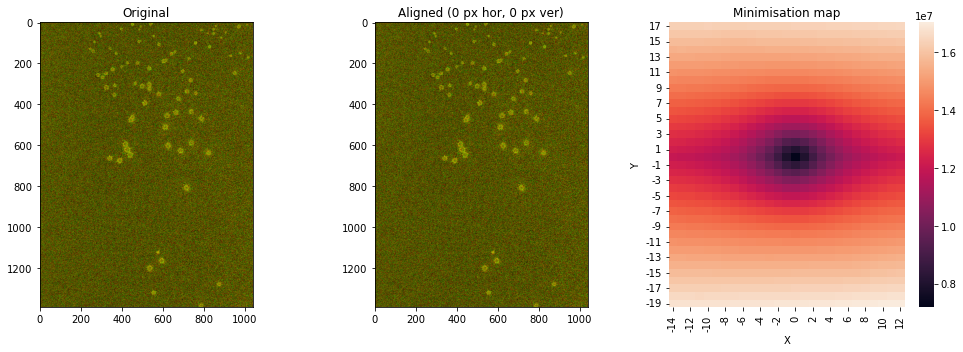

In [4]:
# actual dataset - can see offsets of maybe 1 pixel by eye
align_stack('../../data_store/2023-03-01 focal scanning first projections.tif')

Aligning image 0 vs 1


Trying possible offsets: 100%|██████████| 999/999 [00:09<00:00, 106.55it/s]


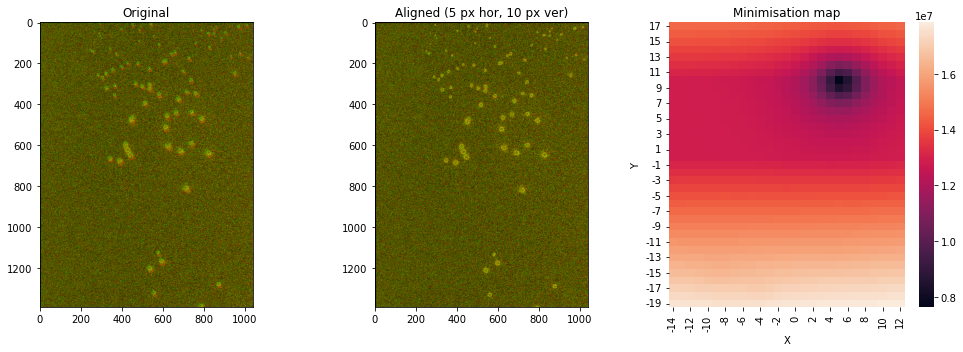

Aligning image 1 vs 2


Trying possible offsets: 100%|██████████| 999/999 [00:10<00:00, 96.26it/s] 


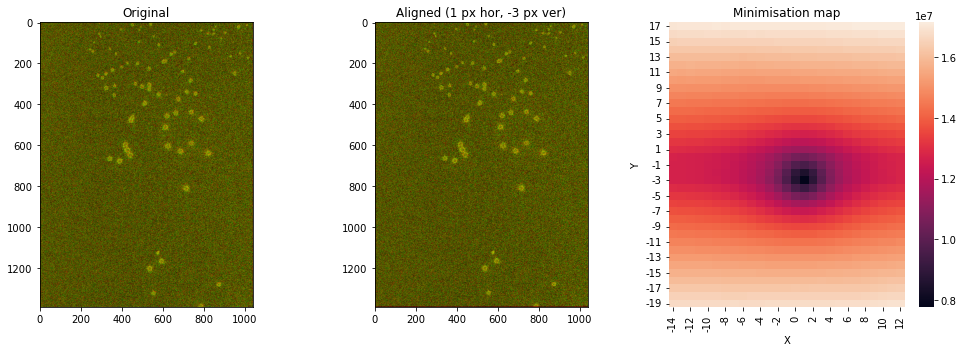

Aligning image 2 vs 3


Trying possible offsets: 100%|██████████| 999/999 [00:09<00:00, 106.79it/s]


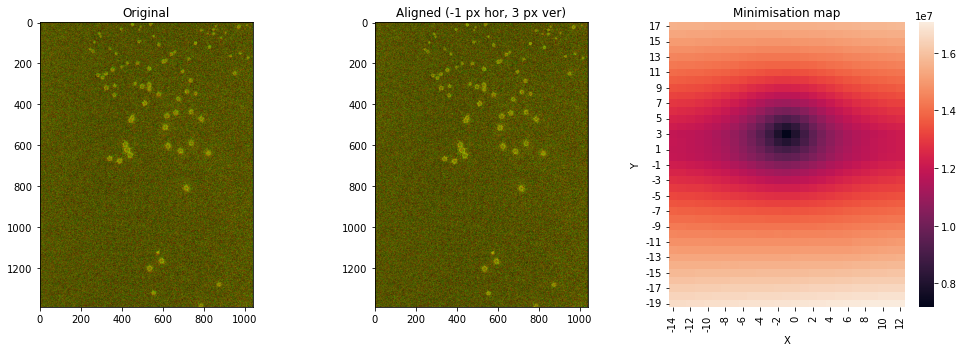

In [5]:
# manually misaligned dataset
align_stack('../../data_store/2023-03-01 focal scanning first projections_misaligned.tif')

Works perfectly for the manually misaligned dataset, but minimises on zero for our actual dataset. So either our actual data is already properly aligned (to within +/- 1 pixel), or the code cannot detect such a small shift. 